# This code is fully functional code 
# Only run in GOOGLE COLAB
# If you run in local machine -> It will take 50 GigaBytes of storage
## By mistake also do not run in local machine

# ******************************************************************************************************************************************************

# Object Detection with TensorFlow and COCO

In [ ]:
# In Google Colab remove the triple quotations
''' 
# Remove all visible content
!rm -rf /content/*

# Clear hidden directories and caches
!rm -rf /root/.cache/*
!rm -rf /root/.config/*
!rm -rf /root/.local/*
!rm -rf /root/.keras/*
!rm -rf /root/.tensorflow_datasets/*
'''

In [20]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   43G   71G  38% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G  4.0K  5.7G   1% /dev/shm
/dev/root       2.0G  1.2G  775M  61% /usr/sbin/docker-init
/dev/sda1       119G  115G  4.1G  97% /kaggle/input
tmpfs           6.4G  124K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [21]:
# %% [markdown]
# # **Object Detection with Faster R-CNN on COCO Dataset**
# *(Run all cells sequentially in Google Colab)*

# %% [code]
# Step 1: Install required packages
!pip install tensorflow tensorflow-hub tensorflow-datasets matplotlib pillow

In [22]:
# %% [code]
# Step 2: Imports
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np

In [23]:
# %% [code]
# Step 3: Load Model (Colab-optimized)
# @title Select Model Resolution
MODEL_RESOLUTION = "640x640"  # @param ["640x640", "1024x1024"]

model_url = f"https://www.kaggle.com/models/tensorflow/faster-rcnn-inception-resnet-v2/TensorFlow2/{MODEL_RESOLUTION}/1"
detector = hub.load(model_url)

print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [24]:
# %% [code]
# Step 4: Load COCO Dataset (disk-friendly version)
# @title Dataset Settings
SAMPLE_SIZE = 3  # @param {type:"slider", min:1, max:10, step:1}

# First clean up any existing partial downloads
!rm -rf /root/tensorflow_datasets/coco  # Clear previous attempts

# Load with explicit data_dir to monitor space
try:
    # Load only metadata first (tiny download)
    _, info = tfds.load('coco/2017',
                       with_info=True,
                       data_dir='/content/limited_coco',  # Custom location
                       download_and_prepare_kwargs={'download_config': tfds.download.DownloadConfig(
                           manual_dir='/content/limited_coco',
                           extract_dir='/content/limited_coco_extract',
                           max_examples_per_split=SAMPLE_SIZE)  # Critical limit
                       })

    coco_labels = info.features['objects']['label'].names

    # Load actual samples with strict limits
    dataset = tfds.load('coco/2017',
                       split=f'validation[:{SAMPLE_SIZE}]',  # Hard limit
                       data_dir='/content/limited_coco',
                       download=False)  # Prevent re-download

    print(f"✅ Successfully loaded {SAMPLE_SIZE} samples")

except Exception as e:
    print(f"⚠️ Error: {str(e)}")
    !df -h  # Show disk usage
    !du -sh /content/limited_coco*  # Show dataset size
    raise

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3 [00:00<?, ? examples/s]

Shuffling /content/limited_coco/coco/2017/incomplete.N0UMUL_1.1.0/coco-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/3 [00:00<?, ? examples/s]

Shuffling /content/limited_coco/coco/2017/incomplete.N0UMUL_1.1.0/coco-validation.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/3 [00:00<?, ? examples/s]

Shuffling /content/limited_coco/coco/2017/incomplete.N0UMUL_1.1.0/coco-test.tfrecord*...:   0%|          | 0/3…

Dataset coco downloaded and prepared to /content/limited_coco/coco/2017/1.1.0. Subsequent calls will reuse this data.
✅ Successfully loaded 3 samples


In [29]:
# %% [code] Fixed Visualization Function
def visualize_detections(image, detections, threshold=0.5):
    """Draw bounding boxes with safe label handling"""
    draw = ImageDraw.Draw(image)
    width, height = image.size

    for i in range(len(detections['scores'])):
        if detections['scores'][i] > threshold:
            # 1. Handle box coordinates
            ymin, xmin, ymax, xmax = detections['boxes'][i]
            left, right = xmin * width, xmax * width
            top, bottom = ymin * height, ymax * height

            # 2. Safe class label handling
            class_id = detections['classes'][i]
            try:
                # Adjust for 1-based COCO indexing if needed
                adjusted_id = class_id - 1 if class_id > len(coco_labels) else class_id
                class_name = coco_labels[adjusted_id]
            except IndexError:
                class_name = f"Class {class_id}"  # Fallback for unknown classes

            # 3. Draw elements
            draw.rectangle([(left, top), (right, bottom)], outline='red', width=3)
            label = f"{class_name}: {int(detections['scores'][i]*100)}%"
            draw.text((left, top), label, fill='red')

# %% [code] Verification Step
print("Total COCO labels:", len(coco_labels))
print("Sample class IDs:", detections['classes'][:5])  # Inspect first 5 detections

Total COCO labels: 80
Sample class IDs: [65 64 64 62 44]


Input tensor specs: (1, 483, 640, 3) <dtype: 'uint8'>
Input tensor specs: (1, 426, 640, 3) <dtype: 'uint8'>
Input tensor specs: (1, 640, 586, 3) <dtype: 'uint8'>


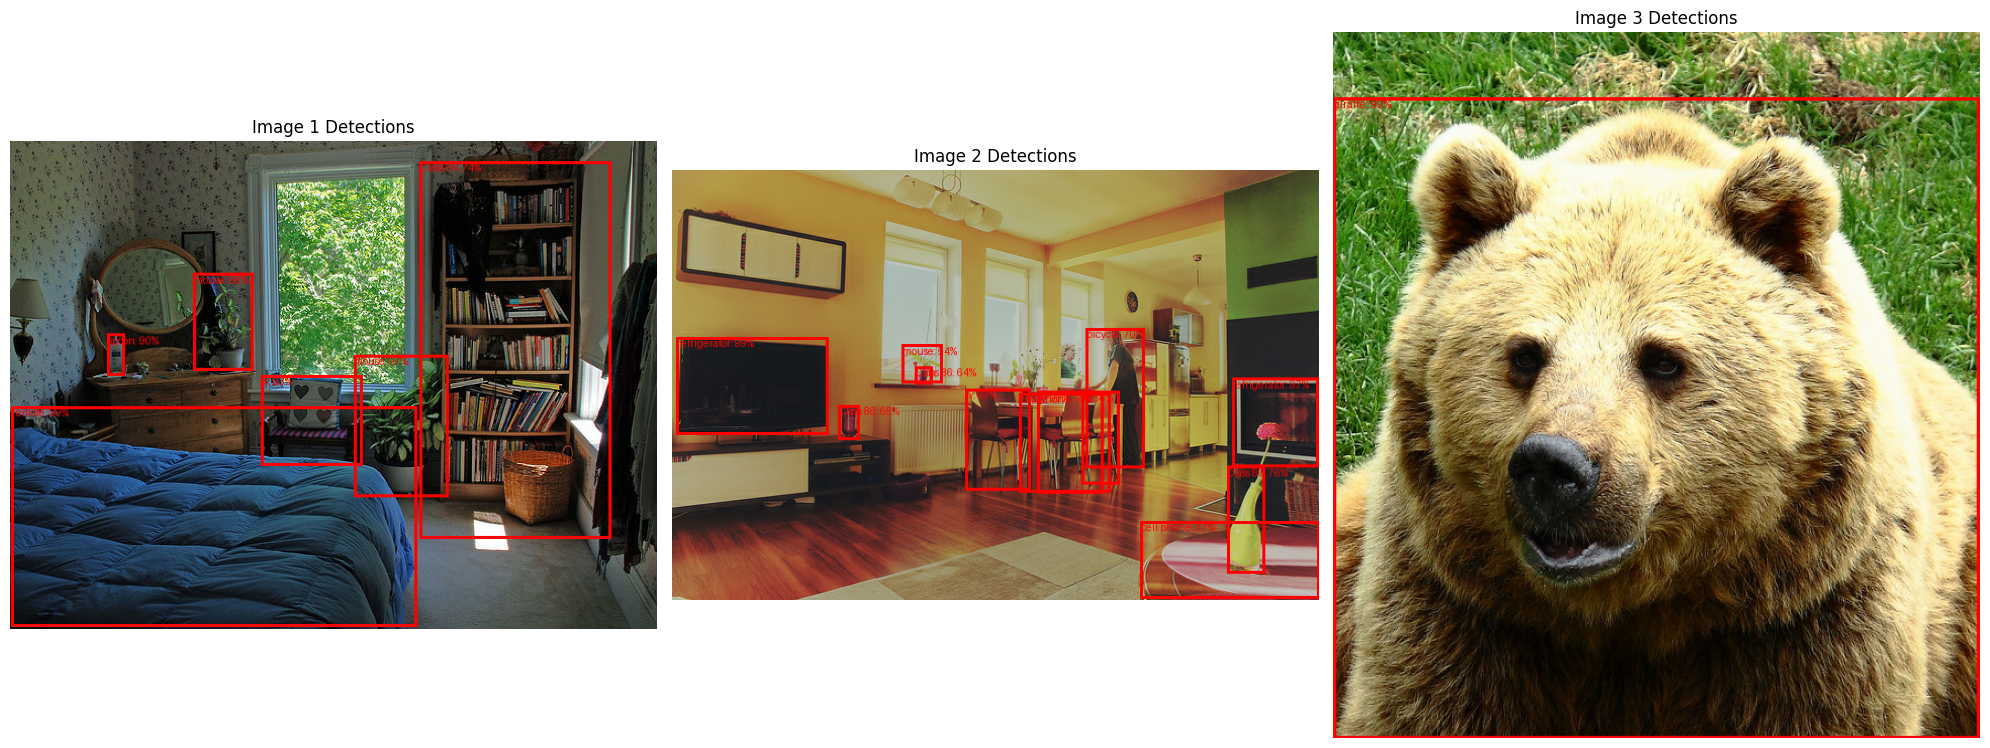


=== Detection Statistics ===
Total COCO labels available: 80
Detected class IDs in first image: [23 23 23 18 67 63 22 23 15 15 23 15 17 67 15 18 67 23 76 65 63 20 21 65
 88 23  1 63 23 23 23 65  3 84  1 15 84 67 73 88 62 23 81  9 19 22 20 15
 65 76 63 20 22 18 76 70 67 17 17 23 23  9 23 15 67 23 62 76 17 65 15 73
  1 18  1 81 21 16 63 15 84 63 17 18  1 15 23  6 41  1  8  9 73 15 76  3
 23  3  1 51]
Corresponding scores: [9.9997163e-01 1.0792477e-01 2.9280527e-02 2.4080588e-02 2.2044528e-02
 1.4467154e-02 1.1729287e-02 9.2473608e-03 8.0889342e-03 7.5673130e-03
 7.5180191e-03 7.2720274e-03 6.8036532e-03 6.1963997e-03 6.0967961e-03
 5.5367472e-03 5.4630060e-03 4.7692559e-03 4.7280164e-03 4.1804966e-03
 4.1435873e-03 3.7256116e-03 3.5183844e-03 3.2639187e-03 3.2274870e-03
 3.2195402e-03 2.9229487e-03 2.6297439e-03 2.6099258e-03 2.3175450e-03
 1.9040564e-03 1.9033765e-03 1.8773270e-03 1.8609295e-03 1.7735290e-03
 1.7515939e-03 1.7265874e-03 1.7140916e-03 1.6572091e-03 1.5487582e-03
 1.3783

In [30]:
# %% [code] Display Detected Images
# @title Visualization Settings
CONFIDENCE_THRESHOLD = 0.5  # @param {type:"slider", min:0, max:1, step:0.05}
MAX_IMAGES_TO_SHOW = 3      # @param {type:"slider", min:1, max:10, step:1}

# Create a figure with subplots
fig, axes = plt.subplots(ncols=min(MAX_IMAGES_TO_SHOW, SAMPLE_SIZE),
                        figsize=(20, 8),
                        squeeze=False)

# Process and display images
for idx, example in enumerate(dataset.take(MAX_IMAGES_TO_SHOW)):
    # Get the image tensor
    image_tensor = example['image']

    # Convert to PIL Image (for visualization only)
    image_pil = Image.fromarray(image_tensor.numpy())

    # Run detection (using original tensor)
    detections = detect_objects(image_tensor)

    # Visualize detections
    visualize_detections(image_pil, detections, threshold=CONFIDENCE_THRESHOLD)

    # Display in subplot
    ax = axes[0, idx]
    ax.imshow(image_pil)
    ax.set_title(f"Image {idx+1} Detections")
    ax.axis('off')

plt.tight_layout()
plt.show()

# %% [code] Additional Debug Info
print("\n=== Detection Statistics ===")
print(f"Total COCO labels available: {len(coco_labels)}")
print(f"Detected class IDs in first image: {detections['classes']}")
print(f"Corresponding scores: {detections['scores']}")